In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from pandas.api.types import CategoricalDtype
from plotnine import ggplot, aes, geom_line, labs, theme, facet_wrap, scale_color_manual
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/ground_station.csv')
df = df.drop("Created_at",axis=1)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df = df.sort_values('Timestamp').reset_index(drop=True)
df = df.set_index('Timestamp')

In [3]:
df.describe()

,Longitude,Latitude,Temperature,Humidity,Precipitation,Wind_Speed_kmh,Wind_Direction,Soil_Moisture,Soil_Temperature
count,115673.000000,1.156730e+05,115673.000000,115673.000000,115673.000000,115673.000000,115673.00000,115673.000000,109974.000000
mean,-119.700698,4.985965e+01,10.701321,68.941043,0.005780,1.570272,179.17259,7690.919999,10.579231
std,0.000000,7.105458e-15,11.029890,23.906514,0.533921,1.537215,115.98962,1917.643090,11.479107
min,-119.700698,4.985965e+01,-20.640000,6.000000,0.000000,0.000000,0.00000,-1.000000,-11.560000
25%,-119.700698,4.985965e+01,0.650000,50.600000,0.000000,0.400000,122.00000,7232.000000,0.000000
50%,-119.700698,4.985965e+01,10.930000,71.500000,0.000000,1.350000,168.00000,8128.000000,9.810000
75%,-119.700698,4.985965e+01,18.090000,91.100000,0.000000,2.240000,311.00000,8816.000000,16.930000
max,-119.700698,4.985965e+01,43.430000,100.000000,119.862600,37.390000,359.00000,10288.000000,54.680000


In [4]:
print(f"df.index.max(): {df.index.max()}")
print(f"df.index.min(): {df.index.min()}")

df.index.max(): 2024-09-16 06:15:19
df.index.min(): 2022-08-03 19:49:10


In [5]:
diffs = df.index.to_series().diff()
gaps = diffs[diffs > pd.Timedelta(hours=6)]

# Para cada gap, mostrar a data anterior (início do gap) e a atual (fim do gap)
for idx in gaps.index:
    end = idx
    start = df.index[df.index.get_loc(idx) - 1]
    print(f"Gap de {gaps.loc[idx]} entre {start} e {end}")

Gap de 90 days 06:47:15 entre 2022-12-17 13:04:40 e 2023-03-17 19:51:55
Gap de 2 days 21:17:05 entre 2023-03-17 20:11:55 e 2023-03-20 17:29:00
Gap de 1 days 02:55:38 entre 2023-03-20 18:49:00 e 2023-03-21 21:44:38
Gap de 0 days 23:28:24 entre 2023-03-21 22:04:38 e 2023-03-22 21:33:02
Gap de 3 days 03:34:49 entre 2023-03-22 22:53:02 e 2023-03-26 02:27:51
Gap de 7 days 12:05:00 entre 2023-03-26 06:47:51 e 2023-04-02 18:52:51
Gap de 119 days 06:53:58 entre 2023-04-05 07:43:01 e 2023-08-02 14:36:59
Gap de 8 days 22:05:56 entre 2024-01-11 23:27:04 e 2024-01-20 21:33:00
Gap de 12 days 16:18:26 entre 2024-01-21 03:23:00 e 2024-02-02 19:41:26
Gap de 116 days 19:56:02 entre 2024-02-03 00:01:26 e 2024-05-29 19:57:28


In [6]:
diffs = df.index.to_series().diff().value_counts()
print(diffs)

Timestamp
0 days 00:05:00      115296
0 days 00:35:00         274
0 days 01:05:00          48
0 days 00:05:01          14
0 days 01:35:00          13
0 days 00:05:10           5
0 days 02:35:00           2
2 days 21:17:05           1
0 days 00:29:51           1
0 days 00:45:04           1
90 days 06:47:15          1
3 days 03:34:49           1
0 days 23:28:24           1
1 days 02:55:38           1
7 days 12:05:00           1
0 days 01:05:10           1
119 days 06:53:58         1
0 days 03:05:00           1
0 days 00:04:49           1
0 days 02:05:00           1
0 days 03:35:00           1
0 days 00:35:01           1
8 days 22:05:56           1
12 days 16:18:26          1
116 days 19:56:02         1
0 days 00:03:20           1
0 days 00:04:17           1
Name: count, dtype: int64


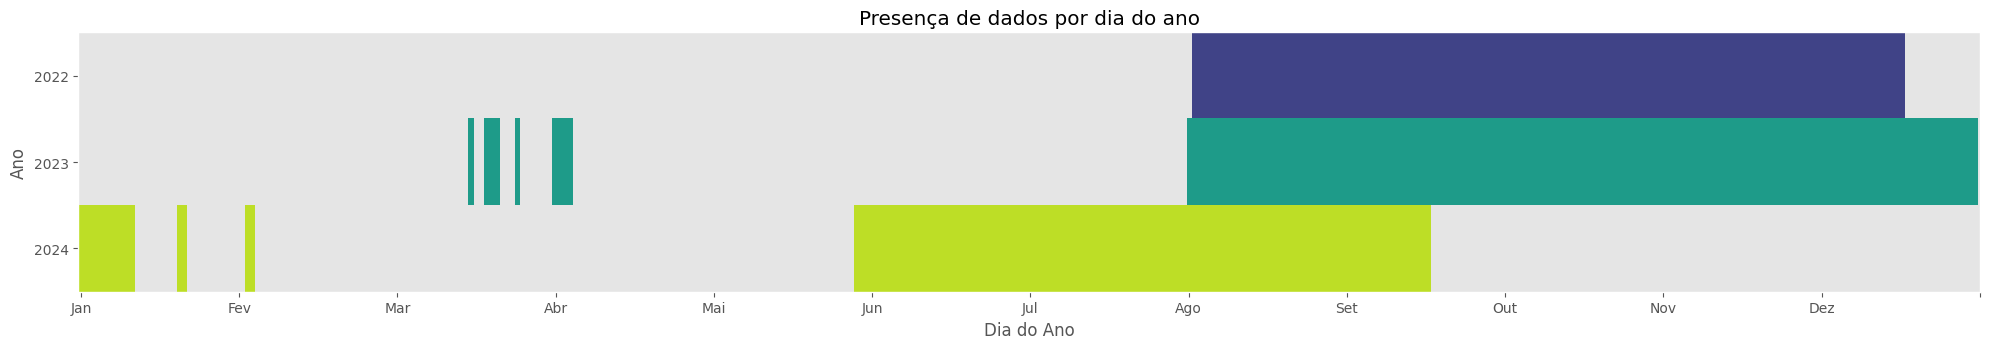

In [10]:
presence = pd.Series(1, index=df.index)
presence = presence.resample('D').max()

# Criar DataFrame com info de data
presence_df = presence.to_frame('present')
presence_df['year'] = presence_df.index.year
presence_df['day_of_year'] = presence_df.index.dayofyear

# Criar matriz de presença por ano x dia
matrix = presence_df.pivot(index='year', columns='day_of_year', values='present')

# Criar colormap com uma cor por ano
years = matrix.index
n_years = len(years)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, n_years))
cmap = mcolors.ListedColormap(colors)
data_colored = np.array([
    row * i if not np.all(np.isnan(row)) else np.nan
    for i, row in enumerate(matrix.values, start=1)
])

# Plotar
plt.figure(figsize=(20, n_years * 1.2))
plt.imshow(data_colored, aspect='auto', cmap=cmap, interpolation='none')
plt.xlabel('Dia do Ano')
plt.ylabel('Ano')
plt.title('Presença de dados por dia do ano')
plt.xticks(np.linspace(0, 365, 13), labels=['Jan','Fev','Mar','Abr','Mai','Jun','Jul','Ago','Set','Out','Nov','Dez',''])
plt.yticks(ticks=np.arange(len(years)), labels=years)
plt.grid(False)
plt.tight_layout()
plt.show()

Definir o período de interesse (últimos 365 dias até a última data disponível)

In [87]:
end = df.index.max()
start = end - pd.Timedelta(days=365)

Gerar índice completo com frequência regular (por ex. 30 minutos: '30T', ou 1 hora: 'H')


In [88]:
full_idx = pd.date_range(start=start, end=end, freq='5min')
print(f"Full index: {full_idx}")

Full index: DatetimeIndex(['2023-09-17 06:15:19', '2023-09-17 06:20:19',
               '2023-09-17 06:25:19', '2023-09-17 06:30:19',
               '2023-09-17 06:35:19', '2023-09-17 06:40:19',
               '2023-09-17 06:45:19', '2023-09-17 06:50:19',
               '2023-09-17 06:55:19', '2023-09-17 07:00:19',
               ...
               '2024-09-16 05:30:19', '2024-09-16 05:35:19',
               '2024-09-16 05:40:19', '2024-09-16 05:45:19',
               '2024-09-16 05:50:19', '2024-09-16 05:55:19',
               '2024-09-16 06:00:19', '2024-09-16 06:05:19',
               '2024-09-16 06:10:19', '2024-09-16 06:15:19'],
              dtype='datetime64[ns]', length=105121, freq='5min')


Reindexar o DataFrame para esse índice “cheio”

In [99]:
df_full = df.reindex(full_idx)

In [102]:
len(df_full)

105121

In [106]:
diffs = df_full.index.to_series().diff().value_counts()
print(diffs)

0 days 00:05:00    105120
Name: count, dtype: int64


In [ ]:
iso = IsolationForest(contamination='auto', random_state=42)
iso.fit(residuals)

In [ ]:
flags = iso.predict(residuals)
is_multivariate_anomaly = pd.Series(flags == -1, index=residuals.index)
df['is_multivariate_anomaly'] = is_multivariate_anomaly
df.head()

In [ ]:
print('Foram encontrados {} outliers'.format(is_multivariate_anomaly.sum()))

In [ ]:
df_clean = df.copy()
for col, stl_res in decomps.items():
    cleaned_series = df[col].copy()
    cleaned_series[is_multivariate_anomaly] = (stl_res.trend + stl_res.seasonal)[is_multivariate_anomaly]
    df_clean[col] = cleaned_series
df_clean.drop(columns=['is_multivariate_anomaly'], inplace=True)
df.drop(columns=['is_multivariate_anomaly'], inplace=True)
df_clean.head()

In [ ]:
print('--- Original ---')
print(df.describe())
print('--- Limpo ---')
print(df_clean.describe())

In [ ]:
orig_long = (
    df
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='original')
)

clean_long = (
    df_clean
    .reset_index()
    .melt(id_vars='Timestamp',
          var_name='variable',
          value_name='value')
    .assign(type='cleaned')
)

combined = pd.concat([orig_long, clean_long], ignore_index=True)
type_order = CategoricalDtype(['original', 'cleaned'], ordered=True)
combined['type'] = combined['type'].astype(type_order)

plot = (
    ggplot(combined, aes('Timestamp', 'value', color='type'))
    + geom_line()
    + facet_wrap('~variable', scales='free_y', ncol=2)
    + scale_color_manual(values=['firebrick', 'navy'])
    + labs(
        title='Comparação: valores originais vs pós-tratamento',
        x='Timestamp',
        y='Valor',
        color='Série'
    )
    + theme(figure_size=(10, 6))
)

plot.show()

In [ ]:
df = df_clean

In [ ]:
#Transformar Wind_Direction (porque ângulo 0° e 360° são "iguais")
df['Wind_Dir_Sin'] = np.sin(np.deg2rad(df['Wind_Direction']))
df['Wind_Dir_Cos'] = np.cos(np.deg2rad(df['Wind_Direction']))
df['Precipitation_log'] = np.log1p(df['Precipitation'])

df.drop(columns=['Wind_Direction'], inplace=True)
df.drop(columns=['Precipitation'], inplace=True)

In [ ]:
profile = ProfileReport(df, title='Profile Report')
profile.to_file('profile_report.html')

TypeError: `df must be either a `pandas.DataFrame` or a `pyspark.sql.DataFrame`, but got <class 'NoneType'>.If using Spark, make sure PySpark is installed.

In [ ]:
df.reset_index(inplace=True)
# 1) Assegure que o índice ou coluna seja datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 2) Unix time normalizado (feature contínua)
df['ts_unix'] = df['Timestamp'].astype(int) // 10**9
df['ts_norm'] = (df['ts_unix'] - df['ts_unix'].mean()) / df['ts_unix'].std()

# 3) Componentes cíclicos do dia, do ano e da semana
# hora do dia
h = df['Timestamp'].dt.hour + df['Timestamp'].dt.minute/60
df['hour_sin'] = np.sin(2 * np.pi * h / 24)
df['hour_cos'] = np.cos(2 * np.pi * h / 24)

# dia do ano
doy = df['Timestamp'].dt.dayofyear + h/24
df['doy_sin'] = np.sin(2 * np.pi * doy / 365)
df['doy_cos'] = np.cos(2 * np.pi * doy / 365)

# dia da semana
dow = df['Timestamp'].dt.dayofweek
df['dow_sin'] = np.sin(2 * np.pi * dow / 7)
df['dow_cos'] = np.cos(2 * np.pi * dow / 7)

# 4) Δt entre observações (seu índice for ordenado)
df = df.sort_values('Timestamp')
df['delta_t'] = df['ts_unix'].diff().fillna(0)
df['delta_t_norm'] = (df['delta_t'] - df['delta_t'].mean()) / df['delta_t'].std()

In [ ]:
num_cols = df.select_dtypes(include=['number']).columns
df[num_cols] = df[num_cols].round(3)

In [ ]:
df['diff'] = df['Timestamp'].diff()
max_gap = pd.Timedelta(hours=4)
df['is_break'] = df['diff'] > max_gap
df['segment'] = df['is_break'].cumsum().fillna(0).astype(int)

print("Máximo intervalo entre pontos:", df['diff'].max())
print("Segmentos encontrados:", df['segment'].unique())

for seg, grp in df.groupby('segment'):
    count = len(grp)
    if count > 150:
        start_Timestamp = grp['Timestamp'].min().strftime('%Y-%m-%d %H:%M:%S')
        end_Timestamp   = grp['Timestamp'].max().strftime('%Y-%m-%d %H:%M:%S')
        filename = f'serie_segmento_{seg}.csv'
        grp = grp.drop('diff', axis=1)
        grp = grp.drop('is_break', axis=1)
        grp = grp.drop('segment', axis=1)
        grp = grp.drop('index', axis =1)
        grp = grp.set_index('Timestamp')
        grp = grp.resample('30min').mean()
        grp = grp.interpolate(method='linear')
        grp = grp.ffill().bfill()
        grp.to_csv(filename)
        print(f'Criado: {filename} | Segmento {seg}: {start_Timestamp} → {end_Timestamp} ({len(grp)} registros)')